# Figure 1

Figure 1 of the manuscript (Overview of concept embedding algorithms) intends to explain concept embedding and to display how nodes that represent siomilar concepts often cluster together (1C) and how similar analogies (relations between pairs of concepts) often point in a similar direction. The notebook shows how we generated the data for these figures from the embeddings used for the project. Note that the publications in the manuscript were generated from the same data using a commercial illustrator software. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from kcet import Wordvec2Cosine

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035#.YTyvZXspBl9
Download the four files to a local directory and enter the path of this directory in the following input dialog
- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt

The constructor of ``Wordvec2Cosine`` loads the word embeddings and words into a pandas dataframe.

In [2]:
data_directory = input()

/home/peter/data/pubmed2vec


In [3]:
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df = w2c.get_embeddings()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388


## MeSH terms representing Lung and Ovarian neoplasms

Note that we transform ids such as "D008175" to "meshd008175" to conform with the way PubTator labels the concepts.

In [4]:
data = [['D008175', 'Lung Neoplasms'],['D000077192','Adenocarcinoma of Lung'],
        ['D002282','Adenocarcinoma, Bronchiolo-Alveolar'],
        ['D001984', 'Bronchial Neoplasms'], ['D002283','Carcinoma, Bronchogenic'],
        ['D002289','Carcinoma, Non-Small-Cell Lung'],['D055752', 'Small Cell Lung Carcinoma'],
        ['D000086002', 'Mesothelioma, Malignant'],['D055613', 'Multiple Pulmonary Nodules'],
        ['D010178', 'Pancoast Syndrome'],['D018202', 'Pulmonary Blastoma'],
        ['D047868', 'Pulmonary Sclerosing Hemangioma']]
df_lung = pd.DataFrame(data, columns = ['MeSH descriptor','Preferred label'])
df_lung['MeSH descriptor'] = df_lung['MeSH descriptor'].apply(lambda meshid: "meshd" + meshid[1:])
df_lung.head()

,MeSH descriptor,Preferred label
0,meshd008175,Lung Neoplasms
1,meshd000077192,Adenocarcinoma of Lung
2,meshd002282,"Adenocarcinoma, Bronchiolo-Alveolar"
3,meshd001984,Bronchial Neoplasms
4,meshd002283,"Carcinoma, Bronchogenic"


In [5]:
data = [['D010051', 'Ovarian Neoplasms'],['D000077216', 'Carcinoma, Ovarian Epithelial'],
['D001948', 'Brenner Tumor'],['D006106', 'Granulosa Cell Tumor'],
['D008539', 'Meigs Syndrome'],['D013798', 'Thecoma'],
['D018269', 'Carcinoma, Endometrioid'],['D018310', 'Sertoli-Leydig Cell Tumor'],
['D018311', 'Luteoma'],['D061325', 'Hereditary Breast and Ovarian Cancer Syndrome']]
df_ovarian = pd.DataFrame(data, columns = ['MeSH descriptor','Preferred label'])
df_ovarian['MeSH descriptor'] = df_ovarian['MeSH descriptor'].apply(lambda meshid: "meshd" + meshid[1:])
df_ovarian.head()

,MeSH descriptor,Preferred label
0,meshd010051,Ovarian Neoplasms
1,meshd000077216,"Carcinoma, Ovarian Epithelial"
2,meshd001948,Brenner Tumor
3,meshd006106,Granulosa Cell Tumor
4,meshd008539,Meigs Syndrome


The following code extracts the vectors for the above concepts.

In [6]:
terms_ovarian = []
for term in df_ovarian['MeSH descriptor']:
    if term in df.index:
        terms_ovarian.append(term)   
ovarian_descendant_df = df.loc[terms_ovarian]
ovarian_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd010051,3.072791,-2.909225,2.060097,4.283984,5.044001,3.521364,-2.625771,2.760182,0.359268,-5.208926,...,-2.067533,4.287587,5.239411,-2.756318,-4.954819,6.051542,-4.532008,0.841578,0.163029,7.852741
meshd000077216,2.953218,-2.924506,2.235753,3.520408,5.433797,2.701469,-3.294727,2.832772,1.040954,-4.847880,...,-2.014151,3.565517,5.502385,-2.904055,-4.857262,6.737767,-4.803393,1.434961,0.291188,7.652975
meshd001948,2.114845,-3.445855,1.451699,1.565399,3.261432,3.478113,-2.297478,1.319301,-0.269439,-4.683348,...,-1.149413,3.438398,3.891533,-1.993584,-2.719943,3.982745,-4.441090,0.150367,0.339359,6.288504
meshd006106,2.453123,-3.225351,2.230294,2.072668,3.829018,3.777840,-2.520633,2.707639,0.578923,-4.629045,...,-1.835440,4.750452,4.482211,-2.425702,-3.002339,4.658401,-4.252470,1.110849,0.992910,7.294141
meshd008539,0.803067,-1.330232,0.654609,1.323322,1.445127,1.163081,-1.423022,0.913188,0.238121,-1.911834,...,-0.472482,1.530111,1.661097,-1.086506,-1.399170,1.991800,-1.244199,0.338743,0.002728,3.760147


In [7]:
terms_lung = []
for term in df_lung['MeSH descriptor']:
    if term in df.index:
        terms_lung.append(term)   
lung_descendant_df = df.loc[terms_lung]
lung_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd008175,3.301751,-4.811779,1.622228,3.851357,2.915498,3.848569,-1.740700,3.183929,0.596785,-5.987088,...,-2.284585,2.975377,5.520432,-2.285758,-3.951332,4.657407,-2.712857,2.580101,0.411148,8.063503
meshd000077192,2.997698,-3.973783,1.934827,3.786742,3.882792,2.959357,-3.569564,3.366140,0.440438,-5.279186,...,-2.126046,3.113032,4.836854,-1.511266,-4.918917,4.884159,-2.259126,2.374165,0.852736,8.293936
meshd002282,2.848512,-4.879909,1.697816,2.488158,2.931847,3.718457,-3.378844,2.231766,-0.157493,-5.216762,...,-1.753302,3.810427,3.903719,-1.857803,-2.950452,4.999865,-2.031033,1.436844,0.751334,8.629610
meshd001984,2.519319,-4.371069,1.705905,2.400935,2.940546,3.295285,-2.396487,1.487975,0.182894,-3.873713,...,-1.255919,3.557224,3.611812,-1.619412,-3.240314,4.556928,-2.965185,1.523867,0.663890,6.811733
meshd002283,3.088353,-4.984658,1.933589,4.056807,4.116179,4.154083,-2.441550,1.894567,0.454660,-5.440371,...,-2.264604,3.463539,5.413669,-1.648129,-3.218199,4.859321,-3.000702,2.721330,0.339338,8.232040


In [8]:
# Define list of colors for plotting.
cvec = ["blue"] * len(terms_lung) + ["green"]* len(terms_ovarian)

In [9]:
lung_ovarian_df = pd.concat([lung_descendant_df, ovarian_descendant_df])

In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(lung_ovarian_df.values)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6817227  0.11548049 0.06351165]


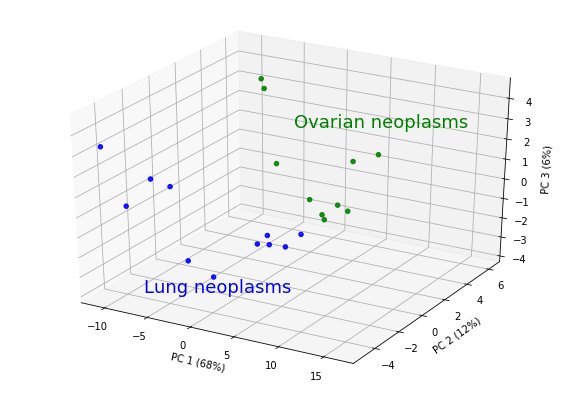

In [11]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], color = cvec,alpha=0.9)
#plt.title("3D scatter plot")
ax.set_xlabel('PC 1 (%.f%%)' % (pca.explained_variance_ratio_[0]*100)) 
ax.set_ylabel('PC 2 (%.f%%)' % (pca.explained_variance_ratio_[1]*100)) 
ax.set_zlabel('PC 3 (%.f%%)' % (pca.explained_variance_ratio_[2]*100))

ax.text(-2, 4, 2, 'Ovarian neoplasms', color='green', size=18)
ax.text(-8, -4, -4, 'Lung neoplasms', color='blue', size=18)
# show plot
plt.show()

# Figure 1d
The following code generates Figure 1D. Note that the labels and appearance of the Figure were optimized with a graphics software to improve the appearance of the published figure.

In [12]:
df_words = df.loc[["lung", "meshd008175", "breast", "meshd001943", "ovary", "meshd010051", "liver", "meshd008113"]]
df_words.head(8)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
lung,3.196993,-4.231648,1.659041,4.174098,2.751357,3.321926,-2.715797,3.439398,0.508167,-6.636255,...,-1.730516,4.045200,5.256654,-2.251897,-3.720957,5.053051,-2.156815,1.889451,0.652380,9.955623
meshd008175,3.301751,-4.811779,1.622228,3.851357,2.915498,3.848569,-1.740700,3.183929,0.596785,-5.987088,...,-2.284585,2.975377,5.520432,-2.285758,-3.951332,4.657407,-2.712857,2.580101,0.411148,8.063503
breast,2.932045,-2.258747,1.727347,3.481520,3.250926,4.625692,-3.668364,3.829142,0.252712,-6.158445,...,-1.614505,5.565101,5.280187,-3.592336,-4.315172,7.719002,-5.337784,1.534341,0.529590,9.611197
meshd001943,3.212003,-1.882929,1.929095,3.227999,3.379572,3.978704,-2.658826,4.842093,0.024247,-5.611629,...,-1.743007,3.623182,4.277930,-3.402141,-5.300494,7.399817,-6.084196,2.057205,0.085744,7.320337
ovary,2.630601,-2.998020,2.116871,3.707161,3.642615,3.256233,-2.412137,3.244543,0.055791,-5.618137,...,-1.668545,5.819878,4.544055,-1.779628,-3.562068,5.432440,-4.451223,0.891037,0.305600,9.005716
meshd010051,3.072791,-2.909225,2.060097,4.283984,5.044001,3.521364,-2.625771,2.760182,0.359268,-5.208926,...,-2.067533,4.287587,5.239411,-2.756318,-4.954819,6.051542,-4.532008,0.841578,0.163029,7.852741
liver,3.179260,-4.553947,1.776016,3.099318,4.230488,4.222075,-3.451780,3.541979,1.000978,-5.536757,...,-0.397900,4.735034,5.977280,-2.495616,-3.424710,4.810229,-3.058471,2.407142,0.092114,10.095568
meshd008113,3.004256,-5.385717,1.737515,2.379135,3.612733,4.857090,-2.498205,2.739218,1.137355,-5.264485,...,-0.762170,4.384346,6.206931,-2.656664,-3.667631,4.676504,-2.116742,1.954225,0.480516,9.376901


In [13]:
# colors for plotting
cvec=["red","darkorange","blue","green","darkturquoise","dimgrey","magenta","black"]

In [14]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_words.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4426887  0.2079397  0.15681323]


In [15]:
pca_result

array([[-4.0315175 ,  2.819825  ,  2.821703  ],
       [-1.5028851 ,  5.3601027 , -3.316365  ],
       [ 3.625251  ,  1.2002119 ,  4.921877  ],
       [ 6.97645   ,  2.4521039 , -1.0929809 ],
       [ 1.8631594 , -4.6537147 ,  1.5988542 ],
       [ 4.9481764 , -3.3027003 , -3.1784227 ],
       [-6.4167542 , -1.8949258 ,  0.69285893],
       [-5.4618807 , -1.9809023 , -2.4475265 ]], dtype=float32)

In [16]:
def plot_arrow(ax, pca_array, i):
    '''
    Add an arrow to the 3D PCA plot
    '''
    start_x, start_y, start_z = pca_array[i][0], pca_array[i][1], pca_array[i][2]
    # magnitudes
    mag_x, mag_y, mag_z = pca_array[i+1][0] - start_x, pca_array[i+1][1]-start_y, pca_array[i+1][2]-start_z
    ax.quiver(
        start_x, start_y, start_z, # <-- starting point of vector
        mag_x, mag_y, mag_z , # <-- directions of vector
        color = 'black', alpha = .8, lw = 2)

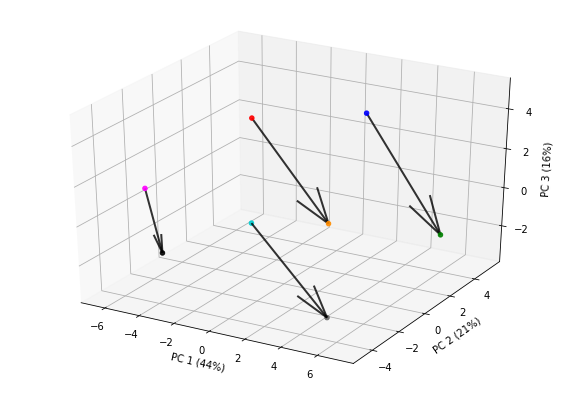

In [17]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], color = cvec,alpha=0.9)
#plt.title("3D scatter plot")
ax.set_xlabel('PC 1 (%.f%%)' % (pca.explained_variance_ratio_[0]*100)) 
ax.set_ylabel('PC 2 (%.f%%)' % (pca.explained_variance_ratio_[1]*100)) 
ax.set_zlabel('PC 3 (%.f%%)' % (pca.explained_variance_ratio_[2]*100))

plot_arrow(ax, pca_result, 0)
plot_arrow(ax, pca_result, 2)
plot_arrow(ax, pca_result, 4)
plot_arrow(ax, pca_result, 6)

plt.show()